In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import itertools
import matplotlib.pyplot as plt

import sampler
import datasets
from earlystopping import EarlyStopping

from sklearn.metrics import accuracy_score, recall_score
from torch.autograd  import  Function

# Acoustic Branch

Inputs for acoustic branch will be N x 40 where N [1,33]  
Time step: (2, 10) (seconds?)  
N: relative duration after feature extraction

In [2]:
class AcousticNet(nn.Module):
    def __init__(self, num_conv_layers = 3, kernel_size = 2, conv_width = 32, num_gru_layers = 2):
        super(AcousticNet, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.conv1 = nn.Conv1d(in_channels=40, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.conv2 = nn.Conv1d(in_channels=conv_width, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.conv3 = nn.Conv1d(in_channels=conv_width, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.conv4 = nn.Conv1d(in_channels=conv_width, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.convs = [self.conv1, self.conv2, self.conv3, self.conv4]
        self.max_pool = nn.MaxPool1d(kernel_size = 2)
        self.relu = nn.ReLU()
        
        self.gru = nn.GRU(input_size=conv_width,hidden_size=32,num_layers=num_gru_layers) # 19 is hardcoded
        self.mean_pool = nn.AvgPool1d(kernel_size=2)
        
    def forward(self, x):
        x = torch.transpose(x, 1, 2) 
#         print(x.shape)
        for i in range(self.num_conv_layers):
            x = self.relu(self.max_pool(self.convs[i](x)))
        x = torch.transpose(x, 1, 2) 
        x, _ = self.gru(x)
        x = torch.transpose(x, 1, 2)
        x = F.adaptive_avg_pool1d(x,1)[:, :, -1]
#         x = self.mean_pool(x)
        return x

In [3]:
# Test dummy input
net = AcousticNet(num_conv_layers = 3, kernel_size = 2, conv_width = 32, num_gru_layers = 2)
batch_size = 8
n_acoustic_channels = 40
duration_acoustic = 1232
test_vec = torch.randn(batch_size, duration_acoustic, n_acoustic_channels) # samples x features (or channels) x N (relative duration)
output = net(test_vec)
print(f'Shape of output: {output.shape}')
# assert output.shape[-1] == 16

Shape of output: torch.Size([8, 32])


# Lexical Branch

In [4]:
# implement GRU (or transformer)
class LexicalNet(nn.Module):
    def __init__(self, num_gru_layers = 2):
        super(LexicalNet, self).__init__()
        # implement GRU (or transformer)
        self.gru = nn.GRU(input_size=768,hidden_size=32,num_layers=num_gru_layers)
        self.mean_pool = nn.AvgPool1d(kernel_size=2) 
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x, _ = self.gru(x)
#         x = self.mean_pool(x)
        x = self.flatten(x)
#         print(x.shape)
        return x

In [5]:
# Test dummy input
net = LexicalNet(num_gru_layers = 2)
batch_size = 8
test_vec = torch.randn(batch_size, 1, 768)
output = net(test_vec)
# assert output.shape[-1] == 16

# Master branch

In [6]:
# class GRL(Function):
#     @staticmethod
#     def forward(self,x):
#         return x
#     @staticmethod
#     def backward(self,grad_output):
#         grad_input = grad_output.neg()
#         return grad_input

In [7]:
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None
    
class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [8]:
class MasterNet(nn.Module):
    def __init__(self, acoustic_modality = True, lexical_modality = True, visual_modality = False,
                 num_conv_layers = 3, kernel_size = 2, conv_width = 32, num_gru_layers = 2,
                 num_dense_layers = 1, dense_layer_width = 32, grl_lambda = .3):
        super(MasterNet, self).__init__()
        
        self.acoustic_modality = acoustic_modality
        self.lexical_modality = lexical_modality
        self.visual_modality = visual_modality
        
        self.acoustic_model = AcousticNet(num_conv_layers = num_conv_layers, kernel_size = kernel_size, 
                                     conv_width = conv_width, num_gru_layers = num_gru_layers)
        self.lexical_model = LexicalNet(num_gru_layers = 2)
        
        # emotion classifier
#         self.dense1_emo = nn.Linear()
#         self.dense2_emo = nn.Linear()
        
        width = 0 # width of the FC layers
        if self.acoustic_modality:
            width += 32
        if self.visual_modality:
            width += 0 # to implement
        if self.lexical_modality:
            width += 32
            
        self.fc_1 = nn.Linear(width, dense_layer_width)
        self.fc_2 = nn.Linear(dense_layer_width, 3)
        self.softmax = nn.Softmax(dim=1)

        self.relu = nn.ReLU()
#         # To implement   
#         if num_dense_layers == 2:
#             self.fc = nn.Sequential()
#             self.linear_1 = nn.Linear(width, dense_layer_width)
#         else:
#             self.fc = 
        
        # confound classifier -- to implement
        self.grl = GradientReversal(lambda_ = grl_lambda)
        self.dense_conv = nn.Linear(width, 2)
#         self.dense2_con = None
        
        
    def forward_a(self, x_a):
        x = x_a
        x = self.acoustic_model(x)
        return x
    
    def forward_l(self, x_l):
        x = torch.unsqueeze(x_l, dim = 1)
        x = self.lexical_model(x)
        return x
    
    def forward_v(self, x_v):
        x = x_v
        return x
    
    def encoder(self, x_v, x_a, x_l):
        if self.visual_modality:
            x_v = self.forward_v(x_v)
        if self.acoustic_modality:
            x_a = self.forward_a(x_a)
        if self.lexical_modality:
            x_l = self.forward_l(x_l)
        
        if self.visual_modality:
            if self.acoustic_modality:
                if self.lexical_modality:
                    x = torch.cat((x_v, x_a, x_l), 1)
                else:
                    x = torch.cat((x_v, x_a), 1)
            else:
                if self.lexical_modality:
                    x = torch.cat((x_v, x_l), 1)
                else:
                    x = x_v
        else:
            if self.acoustic_modality:
                if self.lexical_modality:
                    x = torch.cat((x_a, x_l), 1)
                else:
                    x = x_a
            else:
                x = x_l
        return x

    def confound_model(self, x):
#         x = self.grl.apply(x)
        x = self.grl(x)
        x = self.dense_conv(x)
        x = self.softmax(x)
        return x
    
    # For emotion
    def recognizer(self, x):
#         print(x.shape)
        x = self.relu(self.fc_1(x))
        x = self.fc_2(x)
        x = self.softmax(x)
        return x
    
    def forward(self, x_v, x_a, x_l):
        x = self.encoder(x_v, x_a, x_l)
        emotion_output = self.recognizer(x)
        confound_output = self.confound_model(x)
        
        return emotion_output, confound_output

In [9]:
# Test dummy input
net = MasterNet()
batch_size = 8
n_acoustic_channels = 40
duration_acoustic = 1232
acoustic_features = torch.randn(batch_size, duration_acoustic, n_acoustic_channels) # samples x features (or channels) x N (relative duration)
# lexical_features = torch.randn(batch_size, 1, 300)
lexical_features = torch.randn(batch_size, 768)
visual_features = None
emotion_output, stress_output = net(visual_features, acoustic_features, lexical_features)
print(f'Shape of emotion output: {emotion_output.shape}')
print(f'Shape of stress output: {stress_output.shape}')
print(emotion_output)
print(stress_output)
# assert output.shape[-1] == 16

Shape of emotion output: torch.Size([8, 3])
Shape of stress output: torch.Size([8, 2])
tensor([[0.2728, 0.3606, 0.3666],
        [0.2783, 0.3548, 0.3669],
        [0.2803, 0.3579, 0.3618],
        [0.2831, 0.3492, 0.3677],
        [0.2771, 0.3546, 0.3683],
        [0.2683, 0.3506, 0.3811],
        [0.2721, 0.3630, 0.3649],
        [0.2696, 0.3671, 0.3633]], grad_fn=<SoftmaxBackward>)
tensor([[0.5710, 0.4290],
        [0.5901, 0.4099],
        [0.5560, 0.4440],
        [0.5614, 0.4386],
        [0.5570, 0.4430],
        [0.5166, 0.4834],
        [0.5375, 0.4625],
        [0.5590, 0.4410]], grad_fn=<SoftmaxBackward>)


In [10]:
# Use specific GPU
def get_device():
    if torch.cuda.is_available():  
        dev = "cuda:0" 
    else:  
        dev = "cpu"  
    return torch.device(dev)
device = get_device()

In [11]:
def train_one_folder(model, folder = 0, epochs = 1, verbose = False, learning_rate = 1e-4, patience = 5):
    # Use specific GPU
    device = get_device()

    # Dataloaders    
    train_dataset_file_path = '../dataset/IEMOCAP/' + str(folder) + '/train.csv'
    train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
    test_dataset_file_path = '../dataset/IEMOCAP/' + str(folder) + '/test.csv'
    test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

    # Model, optimizer and loss function
    init_weights(model)
    for param in emotion_recognizer.parameters():
        param.requires_grad = True
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

    criterion = torch.nn.CrossEntropyLoss()

    best_acc = 0.
    best_uar = 0.
    es = EarlyStopping(patience=patience)

    # Train and validate
    for epoch in range(epochs):
        if verbose:
            print('epoch: {}/{}'.format(epoch + 1, epochs))

        train_loss, train_acc = train(train_loader, model,
                                        optimizer, criterion, device)
        test_loss, test_acc, test_uar = test(test_loader, model,
                                                criterion, device)

        if verbose:
            print('train_emotion_loss: {0:.5f}'.format(train_loss['emotion_loss']),
                  'train_emotion_acc: {0:.3f}'.format(train_acc['emotion_acc']),
                  'train_confound_loss: {0:.5f}'.format(train_loss['confound_loss']),
                  'train_confound_acc: {0:.3f}'.format(train_acc['confound_acc']),
                  'test_emotion_loss: {0:.5f}'.format(test_loss['emotion_loss']),
                  'test_emotion_acc: {0:.3f}'.format(test_acc['emotion_acc']),
                  'test_confound_loss: {0:.5f}'.format(test_loss['confound_loss']),
                  'test_confound_acc: {0:.3f}'.format(test_acc['confound_acc']),
                  'test_emotion_uar: {0:.3f}'.format(test_uar['emotion_uar']),
                  'test_confound_uar: {0:.3f}'.format(test_uar['confound_uar']))

        lr_schedule.step(test_loss['loss'])

#         os.makedirs(os.path.join(opt.logger_path, opt.source_domain), exist_ok=True)

#         model_file_name = os.path.join(opt.logger_path, opt.source_domain, 'checkpoint.pth.tar')
#         state = {'epoch': epoch+1, 'emotion_recognizer': emotion_recognizer.state_dict(), 'opt': opt}
#         torch.save(state, model_file_name)

        if test_acc['emotion_acc'] > best_acc:
#             model_file_name = os.path.join(opt.logger_path, opt.source_domain, 'model.pth.tar')
#             torch.save(state, model_file_name)

            best_acc = test_acc['emotion_acc']

        if test_uar['emotion_uar'] > best_uar:
            best_uar = test_uar['emotion_uar']

        if es.step(test_loss['emotion_loss']):
            break

    return best_acc, best_uar

In [12]:
def train_baseline(train_loader, model, optimizer, criterion, device, verbose = False):
    model.train()

    running_loss = 0.
    running_acc = 0.

    groundtruth = []
    prediction = []

    for i, train_data in enumerate(train_loader):
        visual_features, _, acoustic_features, _, lexical_features, _, _, a_labels, _, _ = train_data # UPDATE

        visual_features = visual_features.to(device)
        acoustic_features = acoustic_features.to(device)
        lexical_features = lexical_features.to(device)

        labels = a_labels.to(device)

        optimizer.zero_grad()
        
        emotion_output, stress_output = model(visual_features, acoustic_features, lexical_features)

        emotion_loss = criterion(emotion_output, labels)
#         stress_loss = criterion(stress_output, stress_labels)

        emotion_loss.backward()
#         stress_loss.backward()
        
        optimizer.step() # do we need two optimizers?
        
        running_loss += emotion_loss.item()

        groundtruth.append(labels.tolist())
        predictions = emotion_output.argmax(dim=1, keepdim=True)
        prediction.append(predictions.view_as(labels).tolist())

        if verbose and i > 0 and int(len(train_loader) / 10) > 0 and i % (int(len(train_loader) / 10)) == 0:
            print('.', flush=True, end='')
            
    train_loss = running_loss / len(train_loader)

    groundtruth = list(itertools.chain.from_iterable(groundtruth))
    prediction = list(itertools.chain.from_iterable(prediction))

    train_acc = accuracy_score(prediction, groundtruth)

    return train_loss, train_acc

When we train baseline, the loss from the confound is NOT included in backpropagation, only the loss from the emotion task. 

In [13]:
def train(train_loader, model, optimizer, criterion, device, verbose = False, emotion_dimension = 'arousal', baseline = False):
    model.train()

    running_loss = 0.
    emotion_running_loss = 0.
    confound_running_loss = 0.
    running_acc = 0.

    emotion_groundtruth = []
    emotion_prediction = []
    
    confound_groundtruth = []
    confound_prediction = []

    for i, train_data in enumerate(train_loader):
        visual_features, _, acoustic_features, _, lexical_features, _, v_labels, a_labels, d_labels, s_labels, _ = train_data # UPDATE

        visual_features = visual_features.to(device)
        acoustic_features = acoustic_features.to(device)
        lexical_features = lexical_features.to(device)

        if emotion_dimension == 'arousal':
            emotion_labels = a_labels.to(device)
        elif emotion_dimension == 'valence':
            emotion_labels = v_labels.to(device)
        else:
            print("Invalid emotion dimension")
            return
        confound_labels = s_labels.to(device)

        optimizer.zero_grad()
        
        emotion_predictions, confound_predictions = model(visual_features, acoustic_features, lexical_features)
        
        emotion_loss = criterion(emotion_predictions, emotion_labels)
        confound_loss = criterion(confound_predictions, confound_labels)
        if baseline == True:
            loss = emotion_loss
        else:
            loss = emotion_loss + confound_loss
        
        loss.backward()

        optimizer.step() # do we need two optimizers?
        
        emotion_running_loss += emotion_loss.item()
        confound_running_loss += confound_loss.item()
        running_loss += emotion_running_loss + confound_running_loss

        emotion_groundtruth.append(emotion_labels.tolist())
        emotion_predictions = emotion_predictions.argmax(dim=1, keepdim=True)
        emotion_prediction.append(emotion_predictions.view_as(emotion_labels).tolist())
        
        confound_groundtruth.append(confound_labels.tolist())
        confound_predictions = confound_predictions.argmax(dim=1, keepdim=True)
        confound_prediction.append(confound_predictions.view_as(confound_labels).tolist())

        if verbose and i > 0 and int(len(train_loader) / 10) > 0 and i % (int(len(train_loader) / 10)) == 0:
            print('.', flush=True, end='')
        
    emotion_loss = emotion_running_loss / len(train_loader)
    confound_loss = confound_running_loss / len(train_loader)
    loss = running_loss / len(train_loader)
    train_loss = {'emotion_loss': emotion_loss,
                  'confound_loss': confound_loss,
                  'loss': loss
                 }

    emotion_groundtruth = list(itertools.chain.from_iterable(emotion_groundtruth))
    emotion_prediction = list(itertools.chain.from_iterable(emotion_prediction))
    
    confound_groundtruth = list(itertools.chain.from_iterable(confound_groundtruth))
    confound_prediction = list(itertools.chain.from_iterable(confound_prediction))

    emotion_acc = accuracy_score(emotion_prediction, emotion_groundtruth)
    confound_acc = accuracy_score(confound_prediction, confound_groundtruth)
    avg_acc = (emotion_acc + confound_acc) / 2
    
    train_acc = {'emotion_acc': emotion_acc,
                  'confound_acc': confound_acc
                }

    return train_loss, train_acc

In [14]:
def test_baseline(test_loader, model, criterion, device):
    model.eval()

    running_loss = 0.
    running_acc = 0.

    with torch.no_grad():
        groundtruth = []
        prediction = []

        for i, test_data in enumerate(test_loader):
            visual_features, _, acoustic_features, _, lexical_features, _, v_labels, a_labels, d_labels, _ = test_data # UPDATE

            visual_features = visual_features.to(device)
            acoustic_features = acoustic_features.to(device)
            lexical_features = lexical_features.to(device)

            labels = a_labels.to(device)

            emotion_predictions, confound_predictions = model(visual_features, acoustic_features, lexical_features)
            loss = criterion(emotion_predictions, labels)

            running_loss += loss.item()

            groundtruth.append(labels.tolist())
            emotion_predictions = emotion_predictions.argmax(dim=1, keepdim=True)
            prediction.append(emotion_predictions.view_as(labels).tolist())

        test_loss = running_loss / len(test_loader)

        groundtruth = list(itertools.chain.from_iterable(groundtruth))
        prediction = list(itertools.chain.from_iterable(prediction))

        test_acc = accuracy_score(prediction, groundtruth)
        test_uar = recall_score(prediction, groundtruth, average='macro')

        return test_loss, test_acc, test_uar

In [15]:
def test(test_loader, model, criterion, device, emotion_dimension = 'arousal'):
    model.eval()

    running_loss = 0.
    emotion_running_loss = 0.
    confound_running_loss = 0.
    running_acc = 0.

    with torch.no_grad():
        emotion_groundtruth = []
        emotion_prediction = []

        confound_groundtruth = []
        confound_prediction = []

        for i, test_data in enumerate(test_loader):
            visual_features, _, acoustic_features, _, lexical_features, _, v_labels, a_labels, d_labels, s_labels, _ = test_data # UPDATE

            visual_features = visual_features.to(device)
            acoustic_features = acoustic_features.to(device)
            lexical_features = lexical_features.to(device)
            
            if emotion_dimension == 'arousal':
                emotion_labels = a_labels.to(device)
            elif emotion_dimension == 'valence':
                emotion_labels = v_labels.to(device)
            else:
                print("Invalid emotion dimension")
                return
            confound_labels = s_labels.to(device)

            emotion_predictions, confound_predictions = model(visual_features, acoustic_features, lexical_features)
            
            emotion_loss = criterion(emotion_predictions, emotion_labels)
            confound_loss = criterion(confound_predictions, confound_labels)
            loss = emotion_loss + confound_loss

            emotion_running_loss += emotion_loss.item()
            confound_running_loss += confound_loss.item()
            running_loss += emotion_running_loss + confound_running_loss

            emotion_groundtruth.append(emotion_labels.tolist())
            emotion_predictions = emotion_predictions.argmax(dim=1, keepdim=True)
            emotion_prediction.append(emotion_predictions.view_as(emotion_labels).tolist())

            confound_groundtruth.append(confound_labels.tolist())
            confound_predictions = confound_predictions.argmax(dim=1, keepdim=True)
            confound_prediction.append(confound_predictions.view_as(confound_labels).tolist())

        emotion_loss = emotion_running_loss / len(train_loader)
        confound_loss = confound_running_loss / len(train_loader)
        loss = running_loss / len(train_loader)
        test_loss = {'emotion_loss': emotion_loss,
                     'confound_loss': confound_loss,
                     'loss': loss
                    }

        emotion_groundtruth = list(itertools.chain.from_iterable(emotion_groundtruth))
        emotion_prediction = list(itertools.chain.from_iterable(emotion_prediction))

        confound_groundtruth = list(itertools.chain.from_iterable(confound_groundtruth))
        confound_prediction = list(itertools.chain.from_iterable(confound_prediction))

        emotion_acc = accuracy_score(emotion_prediction, emotion_groundtruth)
        confound_acc = accuracy_score(confound_prediction, confound_groundtruth)
        avg_acc = (emotion_acc + confound_acc) / 2
        test_acc = {'emotion_acc': emotion_acc,
                    'confound_acc': confound_acc
                   }
        
        emotion_uar = recall_score(emotion_prediction, emotion_groundtruth, average='macro')
        confound_uar = recall_score(confound_prediction, confound_groundtruth, average='macro')

        test_uar = {'emotion_uar': emotion_uar,
                    'confound_uar': confound_uar
                   }

        return test_loss, test_acc, test_uar

In [16]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

## Train + Test for Valence and Arousal with adversarial learning

### Audio and Lexical w/ Adversarial for Valence

In [17]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 1/15
Train loss: {'emotion_loss': 1.0388155585944885, 'confound_loss': 0.7170775284563057, 'loss': 909.4616950634968}
Train acc: {'emotion_acc': 0.5328467153284672, 'confound_acc': 0.49914841849148417}
Epoch 2/15
Train loss: {'emotion_loss': 0.9830030271863195, 'confound_loss': 0.694845474763603, 'loss': 869.566779237487}
Train acc: {'emotion_acc': 0.5524330900243309, 'confound_acc': 0.5208029197080292}
Epoch 3/15
Train loss: {'emotion_loss': 0.9401120974280027, 'confound_loss': 0.6786682327433783, 'loss': 835.9506307068618}
Train acc: {'emotion_acc': 0.6098540145985402, 'confound_acc': 0.5875912408759124}
Epoch 4/15
Train loss: {'emotion_loss': 0.8916363859918794, 'confound_loss': 0.6935309836720678, 'loss': 817.5760993589919}
Train acc: {'emotion_acc': 0.6551094890510949, 'confound_acc': 0.521654501216545}
Epoch 5/15
Train loss: {'emotion_loss': 0.8683267759905715, 'confound_loss': 0.6952010280079415, 'loss': 807.9029936671604}
Train acc: {'emotion_acc': 0.6817518248175183, 'co

In [18]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.1973719269848983, 'confound_loss': 0.15259573547756625, 'loss': 40.12333084845821}
Test acc: {'emotion_acc': 0.6531061022539857, 'confound_acc': 0.5508521165475536}
Test uar: {'emotion_uar': 0.4206770733647824, 'confound_uar': 0.5060753352215053}


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


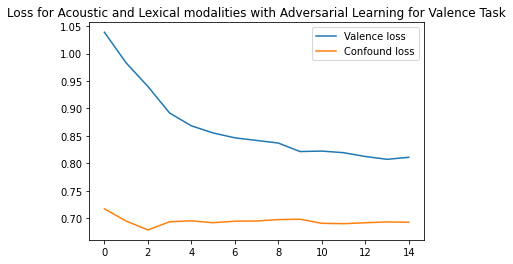

In [19]:
plt.title('Loss for Acoustic and Lexical modalities with Adversarial Learning for Valence Task')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Audio and Lexical w/ Adversarial for Arousal

In [20]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.09763779088217, 'confound_loss': 0.7038916432903899, 'loss': 925.9783397279825}
Train acc: {'emotion_acc': 0.34720194647201946, 'confound_acc': 0.39172749391727496}
Epoch 1/15
Train loss: {'emotion_loss': 1.0651307747289829, 'confound_loss': 0.6951826721545787, 'loss': 913.2090410475369}
Train acc: {'emotion_acc': 0.4615571776155718, 'confound_acc': 0.46763990267639904}
Epoch 2/15
Train loss: {'emotion_loss': 1.0125653195821822, 'confound_loss': 0.6923885769301351, 'loss': 879.0032796905547}
Train acc: {'emotion_acc': 0.5109489051094891, 'confound_acc': 0.5110705596107056}
Epoch 3/15
Train loss: {'emotion_loss': 0.9894456812379889, 'confound_loss': 0.690425122120501, 'loss': 866.6056937430387}
Train acc: {'emotion_acc': 0.5373479318734793, 'confound_acc': 0.540632603406326}
Epoch 4/15
Train loss: {'emotion_loss': 0.9732602490293376, 'confound_loss': 0.6910390025330888, 'loss': 856.7234818737098}
Train acc: {'emotion_acc': 0.5536496350364963, 'c

In [21]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.2185071470208669, 'confound_loss': 0.15249775651595937, 'loss': 42.631907030418226}
Test acc: {'emotion_acc': 0.525563496426608, 'confound_acc': 0.5744914788345244}
Test uar: {'emotion_uar': 0.5529907060801611, 'confound_uar': 0.5365884008894147}


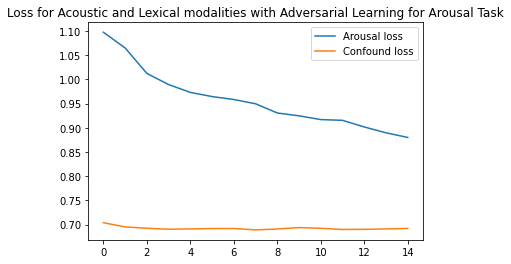

In [22]:
plt.title('Loss for Acoustic and Lexical modalities with Adversarial Learning for Arousal Task')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Acoustic w/ Adversarial for Valence

In [23]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = False, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.021927769835821, 'confound_loss': 0.7195959070023396, 'loss': 900.8392060332667}
Train acc: {'emotion_acc': 0.5434306569343066, 'confound_acc': 0.5054744525547445}
Epoch 1/15
Train loss: {'emotion_loss': 1.0022863044117212, 'confound_loss': 0.6950887364520173, 'loss': 875.8965170523188}
Train acc: {'emotion_acc': 0.5403892944038929, 'confound_acc': 0.5115571776155717}
Epoch 2/15
Train loss: {'emotion_loss': 0.9918455353970658, 'confound_loss': 0.6931339079651851, 'loss': 866.4534006793095}
Train acc: {'emotion_acc': 0.5536496350364963, 'confound_acc': 0.5105839416058394}
Epoch 3/15
Train loss: {'emotion_loss': 0.9932070076465607, 'confound_loss': 0.6948856125197985, 'loss': 870.8746410513783}
Train acc: {'emotion_acc': 0.5506082725060827, 'confound_acc': 0.48722627737226276}
Epoch 4/15
Train loss: {'emotion_loss': 0.9878410393161996, 'confound_loss': 0.6941804812807981, 'loss': 866.4007008573773}
Train acc: {'emotion_acc': 0.5583941605839416, '

In [24]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.22047069918088877, 'confound_loss': 0.15304620430627222, 'loss': 42.93141762332462}
Test acc: {'emotion_acc': 0.5459043430456295, 'confound_acc': 0.5552501374381529}
Test uar: {'emotion_uar': 0.34865162355531093, 'confound_uar': 0.5003007208615599}


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


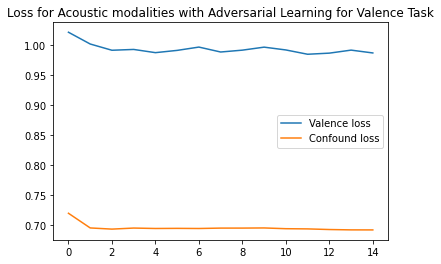

In [25]:
plt.title('Loss for Acoustic modalities with Adversarial Learning for Valence Task')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Acoustic w/ Adversarial for Arousal

In [26]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = False, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.0973886700223856, 'confound_loss': 0.6934770215810041, 'loss': 921.9363896332478}
Train acc: {'emotion_acc': 0.36289537712895376, 'confound_acc': 0.4996350364963504}
Epoch 1/15
Train loss: {'emotion_loss': 1.0626161245752401, 'confound_loss': 0.7008078377186556, 'loss': 910.8582380296887}
Train acc: {'emotion_acc': 0.4754257907542579, 'confound_acc': 0.4871046228710462}
Epoch 2/15
Train loss: {'emotion_loss': 1.020111098131781, 'confound_loss': 0.692953005259139, 'loss': 882.7798202922024}
Train acc: {'emotion_acc': 0.508272506082725, 'confound_acc': 0.5115571776155717}
Epoch 3/15
Train loss: {'emotion_loss': 1.0024439355046832, 'confound_loss': 0.6917925666626326, 'loss': 873.8518754846855}
Train acc: {'emotion_acc': 0.5155717761557178, 'confound_acc': 0.5271289537712895}
Epoch 4/15
Train loss: {'emotion_loss': 0.9951837352741553, 'confound_loss': 0.691006411026424, 'loss': 868.1411060448519}
Train acc: {'emotion_acc': 0.525669099756691, 'conf

In [27]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.20840110829832026, 'confound_loss': 0.15264156953601984, 'loss': 41.454395396236315}
Test acc: {'emotion_acc': 0.6008796041781198, 'confound_acc': 0.5722924683892249}
Test uar: {'emotion_uar': 0.5644593876225025, 'confound_uar': 0.5351960147281785}


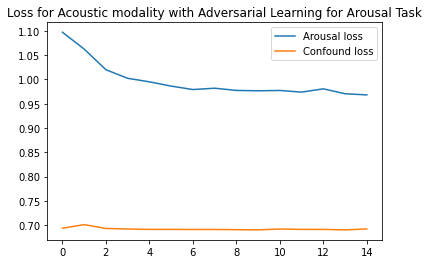

In [28]:
plt.title('Loss for Acoustic modality with Adversarial Learning for Arousal Task')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Lexical w/ Adversarial for Valence

In [29]:
emotion_recognizer = MasterNet(acoustic_modality = False, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.067201223006972, 'confound_loss': 0.7255747584401402, 'loss': 928.261353363091}
Train acc: {'emotion_acc': 0.4475669099756691, 'confound_acc': 0.4192214111922141}
Epoch 1/15
Train loss: {'emotion_loss': 0.9933368473781222, 'confound_loss': 0.7199653189353906, 'loss': 887.7912425096745}
Train acc: {'emotion_acc': 0.5452554744525547, 'confound_acc': 0.3914841849148418}
Epoch 2/15
Train loss: {'emotion_loss': 0.9624571854154423, 'confound_loss': 0.6794419848153563, 'loss': 849.3511198607748}
Train acc: {'emotion_acc': 0.5722627737226277, 'confound_acc': 0.5564476885644769}
Epoch 3/15
Train loss: {'emotion_loss': 0.9318861770026878, 'confound_loss': 0.6793886700840776, 'loss': 831.8237170587486}
Train acc: {'emotion_acc': 0.6208029197080291, 'confound_acc': 0.5712895377128954}
Epoch 4/15
Train loss: {'emotion_loss': 0.898347572825762, 'confound_loss': 0.682027375767667, 'loss': 812.8191029701948}
Train acc: {'emotion_acc': 0.6504866180048662, 'conf

In [30]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.19448686857863623, 'confound_loss': 0.15165784984015304, 'loss': 39.78856842480745}
Test acc: {'emotion_acc': 0.6679494227597581, 'confound_acc': 0.5821880153930731}
Test uar: {'emotion_uar': 0.43340515056511064, 'confound_uar': 0.5575751523020074}


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


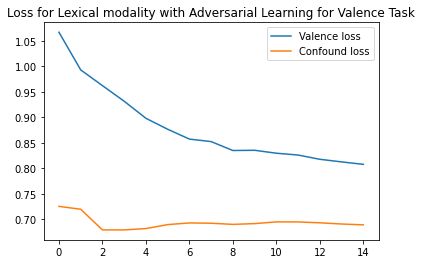

In [31]:
plt.title('Loss for Lexical modality with Adversarial Learning for Valence Task')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Lexical w/ Adversarial for Arousal

In [32]:
emotion_recognizer = MasterNet(acoustic_modality = False, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.098491571292803, 'confound_loss': 0.7122134344818991, 'loss': 928.0820135557118}
Train acc: {'emotion_acc': 0.3344282238442822, 'confound_acc': 0.4099756690997567}
Epoch 1/15
Train loss: {'emotion_loss': 1.0975025838915011, 'confound_loss': 0.7161401702156327, 'loss': 937.3314694370277}
Train acc: {'emotion_acc': 0.34391727493917273, 'confound_acc': 0.3740875912408759}
Epoch 2/15
Train loss: {'emotion_loss': 1.0956543725752181, 'confound_loss': 0.6811152199131042, 'loss': 915.0691563902778}
Train acc: {'emotion_acc': 0.3616788321167883, 'confound_acc': 0.6091240875912409}
Epoch 3/15
Train loss: {'emotion_loss': 1.0886199480132834, 'confound_loss': 0.6916316690843857, 'loss': 915.4385844735784}
Train acc: {'emotion_acc': 0.4059610705596107, 'confound_acc': 0.5250608272506083}
Epoch 4/15
Train loss: {'emotion_loss': 1.0666905817818548, 'confound_loss': 0.6947805926145747, 'loss': 909.5901096651063}
Train acc: {'emotion_acc': 0.44902676399026764, 

In [33]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.22538069139890635, 'confound_loss': 0.15257485326857884, 'loss': 43.500106528227434}
Test acc: {'emotion_acc': 0.49752611324903795, 'confound_acc': 0.577240241891149}
Test uar: {'emotion_uar': 0.4796013103586196, 'confound_uar': 0.5484045944634242}


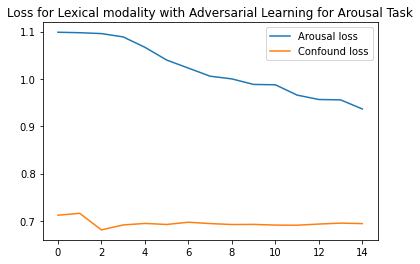

In [34]:
plt.title('Loss for Lexical modality with Adversarial Learning for Arousal Task')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

## Train + Test for Valence and Arousal without adversarial learning

### Audio and Lexical w/o Adversarial for Valence

In [35]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.0193928211115677, 'confound_loss': 0.7009025874768714, 'loss': 895.4353439550456}
Train acc: {'emotion_acc': 0.5405109489051095, 'confound_acc': 0.49318734793187347}
Epoch 1/15
Train loss: {'emotion_loss': 0.9502605285046165, 'confound_loss': 0.7133169133027704, 'loss': 862.4315453596732}
Train acc: {'emotion_acc': 0.5896593673965936, 'confound_acc': 0.4997566909975669}
Epoch 2/15
Train loss: {'emotion_loss': 0.8873363979711607, 'confound_loss': 0.7131134378886872, 'loss': 829.2390346197767}
Train acc: {'emotion_acc': 0.6638686131386862, 'confound_acc': 0.5105839416058394}
Epoch 3/15
Train loss: {'emotion_loss': 0.8617328459882551, 'confound_loss': 0.7160655734372047, 'loss': 812.13623866636}
Train acc: {'emotion_acc': 0.6872262773722628, 'confound_acc': 0.5047445255474453}
Epoch 4/15
Train loss: {'emotion_loss': 0.8474744557754539, 'confound_loss': 0.7165265685737365, 'loss': 805.1050246868152}
Train acc: {'emotion_acc': 0.6997566909975669, 'c

In [36]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.19657589663327435, 'confound_loss': 0.15471346331361666, 'loss': 40.47226746693428}
Test acc: {'emotion_acc': 0.6553051126992854, 'confound_acc': 0.582737768004398}
Test uar: {'emotion_uar': 0.422929253337298, 'confound_uar': 0.291368884002199}


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


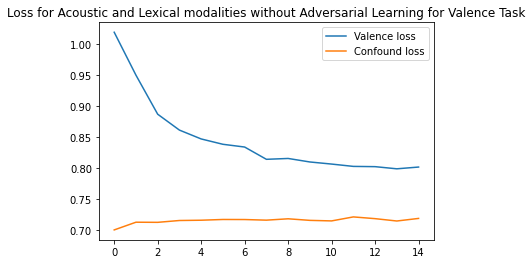

In [37]:
plt.title('Loss for Acoustic and Lexical modalities without Adversarial Learning for Valence Task')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Audio and Lexical w/o Adversarial for Arousal

In [38]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.0942212832577034, 'confound_loss': 0.6980074294462278, 'loss': 923.4710754228589}
Train acc: {'emotion_acc': 0.39099756690997567, 'confound_acc': 0.4645985401459854}
Epoch 1/15
Train loss: {'emotion_loss': 1.032952071859679, 'confound_loss': 0.6990187697489438, 'loss': 896.1840114842245}
Train acc: {'emotion_acc': 0.5045012165450121, 'confound_acc': 0.4750608272506083}
Epoch 2/15
Train loss: {'emotion_loss': 1.00279354144627, 'confound_loss': 0.6989315167243378, 'loss': 879.07956008358}
Train acc: {'emotion_acc': 0.5199513381995133, 'confound_acc': 0.4829683698296837}
Epoch 3/15
Train loss: {'emotion_loss': 0.9796980371271126, 'confound_loss': 0.6995946963821403, 'loss': 864.8521592566011}
Train acc: {'emotion_acc': 0.5489051094890511, 'confound_acc': 0.4807785888077859}
Epoch 4/15
Train loss: {'emotion_loss': 0.9748085782453708, 'confound_loss': 0.6992680624069407, 'loss': 863.3771811698778}
Train acc: {'emotion_acc': 0.5504866180048662, 'conf

In [39]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.21628065070985356, 'confound_loss': 0.15392573061852138, 'loss': 42.55969655612331}
Test acc: {'emotion_acc': 0.5442550852116548, 'confound_acc': 0.5107201759208356}
Test uar: {'emotion_uar': 0.5456482090138933, 'confound_uar': 0.47381065071784056}


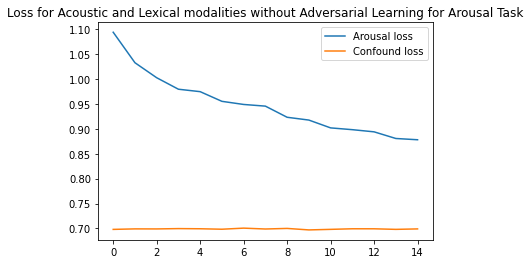

In [40]:
plt.title('Loss for Acoustic and Lexical modalities without Adversarial Learning for Arousal Task')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Acoustic w/o Adversarial for Valence

In [41]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = False, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.0078375493158163, 'confound_loss': 0.7039915258318533, 'loss': 886.4871178860794}
Train acc: {'emotion_acc': 0.564963503649635, 'confound_acc': 0.49744525547445256}
Epoch 1/15
Train loss: {'emotion_loss': 1.000967473893314, 'confound_loss': 0.7079452113882577, 'loss': 880.1677065506751}
Train acc: {'emotion_acc': 0.5447688564476886, 'confound_acc': 0.4978102189781022}
Epoch 2/15
Train loss: {'emotion_loss': 1.0007447278569181, 'confound_loss': 0.7071219938970261, 'loss': 878.615618744365}
Train acc: {'emotion_acc': 0.5429440389294404, 'confound_acc': 0.4989051094890511}
Epoch 3/15
Train loss: {'emotion_loss': 0.998013784449388, 'confound_loss': 0.7075487385116198, 'loss': 879.3294010734628}
Train acc: {'emotion_acc': 0.5451338199513382, 'confound_acc': 0.4927007299270073}
Epoch 4/15
Train loss: {'emotion_loss': 0.9969398695903066, 'confound_loss': 0.7057432327636949, 'loss': 876.3300624048547}
Train acc: {'emotion_acc': 0.5447688564476886, 'con

In [42]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.22071740181993418, 'confound_loss': 0.15557044257449731, 'loss': 43.09353261890347}
Test acc: {'emotion_acc': 0.5453545904343046, 'confound_acc': 0.43045629466739965}
Test uar: {'emotion_uar': 0.1818848551521819, 'confound_uar': 0.5101361113602167}


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


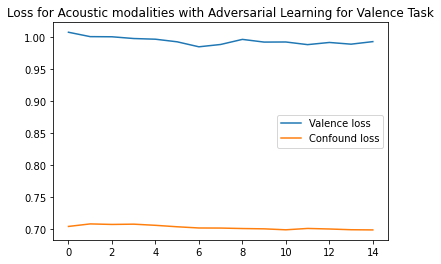

In [43]:
plt.title('Loss for Acoustic modalities without Adversarial Learning for Valence Task')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Acoustic w/o Adversarial for Arousal

In [44]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = False, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.0957638413757667, 'confound_loss': 0.6940859793341113, 'loss': 922.1244090393128}
Train acc: {'emotion_acc': 0.34635036496350363, 'confound_acc': 0.4989051094890511}
Epoch 1/15
Train loss: {'emotion_loss': 1.039717000166266, 'confound_loss': 0.6995557070590179, 'loss': 898.8823647656793}
Train acc: {'emotion_acc': 0.49659367396593673, 'confound_acc': 0.4975669099756691}
Epoch 2/15
Train loss: {'emotion_loss': 1.0092451813040078, 'confound_loss': 0.7037813362560383, 'loss': 882.7621190532288}
Train acc: {'emotion_acc': 0.5169099756690998, 'confound_acc': 0.4942822384428224}
Epoch 3/15
Train loss: {'emotion_loss': 0.9919797349068905, 'confound_loss': 0.7077797996278866, 'loss': 875.4624141940579}
Train acc: {'emotion_acc': 0.5334549878345499, 'confound_acc': 0.4852798053527981}
Epoch 4/15
Train loss: {'emotion_loss': 0.9825380040397904, 'confound_loss': 0.7077850866410519, 'loss': 867.2419932819178}
Train acc: {'emotion_acc': 0.5479318734793187, 

In [45]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.206479929068673, 'confound_loss': 0.16323934866528567, 'loss': 42.238754297624766}
Test acc: {'emotion_acc': 0.6124244090159429, 'confound_acc': 0.417262231995602}
Test uar: {'emotion_uar': 0.5701334243660094, 'confound_uar': 0.208631115997801}


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


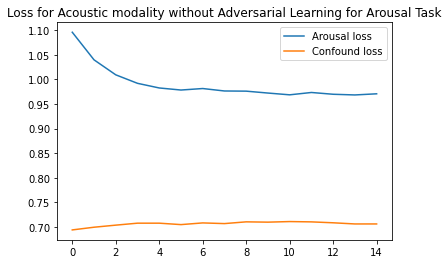

In [46]:
plt.title('Loss for Acoustic modality without Adversarial Learning for Arousal Task')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Lexical w/o Adversarial for Valence

In [47]:
emotion_recognizer = MasterNet(acoustic_modality = False, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.048741316343096, 'confound_loss': 0.6953790821569903, 'loss': 906.8915539888325}
Train acc: {'emotion_acc': 0.4997566909975669, 'confound_acc': 0.4940389294403893}
Epoch 1/15
Train loss: {'emotion_loss': 0.9689130736116306, 'confound_loss': 0.7018544177600846, 'loss': 863.8655724960311}
Train acc: {'emotion_acc': 0.5675182481751825, 'confound_acc': 0.4527980535279805}
Epoch 2/15
Train loss: {'emotion_loss': 0.9157996420034639, 'confound_loss': 0.7099185246205979, 'loss': 839.3857835218716}
Train acc: {'emotion_acc': 0.6335766423357664, 'confound_acc': 0.4509732360097324}
Epoch 3/15
Train loss: {'emotion_loss': 0.8828405903123232, 'confound_loss': 0.7117104799367111, 'loss': 825.102246632314}
Train acc: {'emotion_acc': 0.6628953771289537, 'confound_acc': 0.44659367396593674}
Epoch 4/15
Train loss: {'emotion_loss': 0.8667911262711663, 'confound_loss': 0.7115091076156972, 'loss': 810.0072498355162}
Train acc: {'emotion_acc': 0.6822384428223844, 'c

In [48]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.19657793803437676, 'confound_loss': 0.1547186004164618, 'loss': 40.292617795996165}
Test acc: {'emotion_acc': 0.657504123144585, 'confound_acc': 0.5041231445849368}
Test uar: {'emotion_uar': 0.42473581160819657, 'confound_uar': 0.47167543003907697}


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


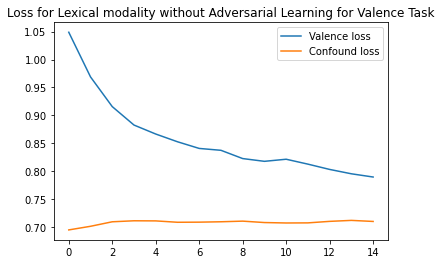

In [49]:
plt.title('Loss for Lexical modality without Adversarial Learning for Valence Task')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Lexical w/o Adversarial for Arousal

In [50]:
emotion_recognizer = MasterNet(acoustic_modality = False, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/15
Train loss: {'emotion_loss': 1.0978294514728428, 'confound_loss': 0.6923722979043708, 'loss': 921.0709826044072}
Train acc: {'emotion_acc': 0.3427007299270073, 'confound_acc': 0.5184914841849149}
Epoch 1/15
Train loss: {'emotion_loss': 1.0915573881757863, 'confound_loss': 0.6931181126763385, 'loss': 918.9498852834048}
Train acc: {'emotion_acc': 0.40693430656934304, 'confound_acc': 0.5171532846715329}
Epoch 2/15
Train loss: {'emotion_loss': 1.069311356961959, 'confound_loss': 0.6942584467653171, 'loss': 910.3521706129675}
Train acc: {'emotion_acc': 0.44148418491484187, 'confound_acc': 0.5008515815085158}
Epoch 3/15
Train loss: {'emotion_loss': 1.035663103605059, 'confound_loss': 0.699295185709278, 'loss': 894.4584297337768}
Train acc: {'emotion_acc': 0.474330900243309, 'confound_acc': 0.5009732360097323}
Epoch 4/15
Train loss: {'emotion_loss': 1.0116299349046403, 'confound_loss': 0.7051742061798675, 'loss': 883.846736131881}
Train acc: {'emotion_acc': 0.5025547445255475, 'con

In [51]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.2259859497213178, 'confound_loss': 0.16381195912333313, 'loss': 44.58553803975944}
Test acc: {'emotion_acc': 0.5052226498075866, 'confound_acc': 0.4156129741616273}
Test uar: {'emotion_uar': 0.4861618605959442, 'confound_uar': 0.30810363836824695}


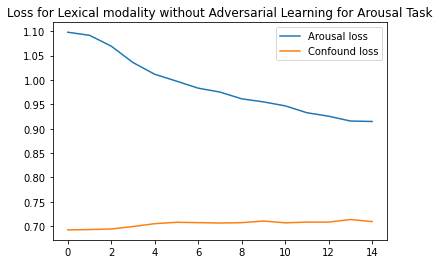

In [52]:
plt.title('Loss for Lexical modality without Adversarial Learning for Arousal Task')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

## Train all folders

In [53]:
acc = []
uar = []

In [54]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 0, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

epoch: 1/10
train_emotion_loss: 1.09711 train_emotion_acc: 0.366 train_confound_loss: 0.69657 train_confound_acc: 0.470 test_emotion_loss: 0.24041 test_emotion_acc: 0.555 test_confound_loss: 0.15680 test_confound_acc: 0.379 test_emotion_uar: 0.483 test_confound_uar: 0.359
epoch: 2/10
train_emotion_loss: 1.04781 train_emotion_acc: 0.491 train_confound_loss: 0.69858 train_confound_acc: 0.473 test_emotion_loss: 0.21792 test_emotion_acc: 0.618 test_confound_loss: 0.15476 test_confound_acc: 0.419 test_emotion_uar: 0.426 test_confound_uar: 0.428
epoch: 3/10


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_emotion_loss: 1.00951 train_emotion_acc: 0.511 train_confound_loss: 0.69309 train_confound_acc: 0.508 test_emotion_loss: 0.21340 test_emotion_acc: 0.618 test_confound_loss: 0.15191 test_confound_acc: 0.600 test_emotion_uar: 0.524 test_confound_uar: 0.587
epoch: 4/10
train_emotion_loss: 0.98646 train_emotion_acc: 0.537 train_confound_loss: 0.68873 train_confound_acc: 0.561 test_emotion_loss: 0.21179 test_emotion_acc: 0.604 test_confound_loss: 0.15129 test_confound_acc: 0.642 test_emotion_uar: 0.551 test_confound_uar: 0.630
epoch: 5/10
train_emotion_loss: 0.97535 train_emotion_acc: 0.558 train_confound_loss: 0.68683 train_confound_acc: 0.570 test_emotion_loss: 0.20868 test_emotion_acc: 0.617 test_confound_loss: 0.15091 test_confound_acc: 0.620 test_emotion_uar: 0.557 test_confound_uar: 0.605
epoch: 6/10
train_emotion_loss: 0.96288 train_emotion_acc: 0.568 train_confound_loss: 0.68652 train_confound_acc: 0.558 test_emotion_loss: 0.20895 test_emotion_acc: 0.604 test_confound_loss: 0.

In [55]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 1, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

epoch: 1/10
train_emotion_loss: 1.09698 train_emotion_acc: 0.350 train_confound_loss: 0.70207 train_confound_acc: 0.498 test_emotion_loss: 0.23862 test_emotion_acc: 0.446 test_confound_loss: 0.16241 test_confound_acc: 0.433 test_emotion_uar: 0.388 test_confound_uar: 0.217
epoch: 2/10
train_emotion_loss: 1.05219 train_emotion_acc: 0.481 train_confound_loss: 0.69889 train_confound_acc: 0.496 test_emotion_loss: 0.21871 test_emotion_acc: 0.573 test_confound_loss: 0.15351 test_confound_acc: 0.471 test_emotion_uar: 0.381 test_confound_uar: 0.519
epoch: 3/10


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_emotion_loss: 1.01409 train_emotion_acc: 0.507 train_confound_loss: 0.69183 train_confound_acc: 0.530 test_emotion_loss: 0.21417 test_emotion_acc: 0.584 test_confound_loss: 0.15137 test_confound_acc: 0.584 test_emotion_uar: 0.500 test_confound_uar: 0.570
epoch: 4/10
train_emotion_loss: 0.98820 train_emotion_acc: 0.543 train_confound_loss: 0.69211 train_confound_acc: 0.522 test_emotion_loss: 0.21211 test_emotion_acc: 0.586 test_confound_loss: 0.15225 test_confound_acc: 0.540 test_emotion_uar: 0.517 test_confound_uar: 0.550
epoch: 5/10
train_emotion_loss: 0.97366 train_emotion_acc: 0.556 train_confound_loss: 0.69264 train_confound_acc: 0.515 test_emotion_loss: 0.20987 test_emotion_acc: 0.580 test_confound_loss: 0.15065 test_confound_acc: 0.615 test_emotion_uar: 0.519 test_confound_uar: 0.605
epoch: 6/10
train_emotion_loss: 0.97378 train_emotion_acc: 0.559 train_confound_loss: 0.68995 train_confound_acc: 0.540 test_emotion_loss: 0.21012 test_emotion_acc: 0.573 test_confound_loss: 0.

In [56]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 2, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

epoch: 1/10
train_emotion_loss: 1.09692 train_emotion_acc: 0.360 train_confound_loss: 0.70355 train_confound_acc: 0.447 test_emotion_loss: 0.28100 test_emotion_acc: 0.472 test_confound_loss: 0.19055 test_confound_acc: 0.364 test_emotion_uar: 0.442 test_confound_uar: 0.329
epoch: 2/10
train_emotion_loss: 1.05867 train_emotion_acc: 0.482 train_confound_loss: 0.70267 train_confound_acc: 0.458 test_emotion_loss: 0.26205 test_emotion_acc: 0.559 test_confound_loss: 0.17768 test_confound_acc: 0.544 test_emotion_uar: 0.455 test_confound_uar: 0.680
epoch: 3/10
train_emotion_loss: 1.01599 train_emotion_acc: 0.501 train_confound_loss: 0.68688 train_confound_acc: 0.544 test_emotion_loss: 0.25802 test_emotion_acc: 0.539 test_confound_loss: 0.17741 test_confound_acc: 0.549 test_emotion_uar: 0.510 test_confound_uar: 0.616
epoch: 4/10
train_emotion_loss: 0.99332 train_emotion_acc: 0.534 train_confound_loss: 0.69050 train_confound_acc: 0.535 test_emotion_loss: 0.25218 test_emotion_acc: 0.574 test_confo

In [ ]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 3, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

epoch: 1/10
train_emotion_loss: 1.09593 train_emotion_acc: 0.370 train_confound_loss: 0.71287 train_confound_acc: 0.465 test_emotion_loss: 0.27589 test_emotion_acc: 0.501 test_confound_loss: 0.18235 test_confound_acc: 0.478 test_emotion_uar: 0.522 test_confound_uar: 0.313
epoch: 2/10
train_emotion_loss: 1.05845 train_emotion_acc: 0.474 train_confound_loss: 0.69847 train_confound_acc: 0.454 test_emotion_loss: 0.26013 test_emotion_acc: 0.529 test_confound_loss: 0.17802 test_confound_acc: 0.490 test_emotion_uar: 0.437 test_confound_uar: 0.483
epoch: 3/10


In [ ]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 4, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(5),acc)

In [ ]:
plt.bar(range(5),uar)

In [ ]:
print(acc)
print(uar)

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame([acc,uar]).T

In [ ]:
np.average(acc)

In [ ]:
np.average(uar)